In [1]:
import numpy as np
import random
import math
from typing import Tuple, Dict

In [2]:
def generate_state() -> int:
    return random.randint(0,63)

def index_to_cartesian(i: int, j: int) -> Tuple[float, float]:
    a = 1
    x = a * j
    if i % 2 == 1:
        x += a / 2
    y = math.sqrt(3) * a / 2 * i
    return x, y

def add_indices(indices1: Tuple[int,...], indices2: Tuple[int,...]) -> Tuple[int,...]:
    return tuple(x + y for x, y in zip(indices1, indices2))

bit_to_neighbor = {
    1: ((0, 1), (0, 1)),
    2: ((1, 0), (1, 1)),
    4: ((1, -1), (1, 0)),
    8: ((0, -1), (0, -1)),
    16: ((-1, -1), (-1, 0)),
    32: ((-1, 0), (-1,1))
}

scattering_rules = {
    0b001001: (0b100100, 0b010010),
    0b010010: (0b001001, 0b100100),
    0b100100: (0b001001, 0b010010),
    0b010101: (0b101010,),
    0b101010: (0b010101,)
}

def generate_lattice(shape: Tuple[int,int]):
    lattice = { (i,j): generate_state() for j in range(shape[1]) for i in range(shape[0]) }
    return lattice

def update_lattice(lattice: Dict[Tuple[int,int], int], N_rows: int, N_cols: int) -> Dict[Tuple[int,int], int]:
    new_lattice = {key: 0 for key in lattice.keys()}
    for site, value in lattice.items():
        if value in scattering_rules:
            value = random.choice(scattering_rules[value])
        is_even_row = site[0] % 2
        for bit, neighbor in bit_to_neighbor.items():
            if value & bit:
                new_site = add_indices(site, neighbor[is_even_row])
                new_site = (new_site[0] % N_rows, new_site[1] % N_cols)
                new_lattice[new_site] |= bit
    return new_lattice

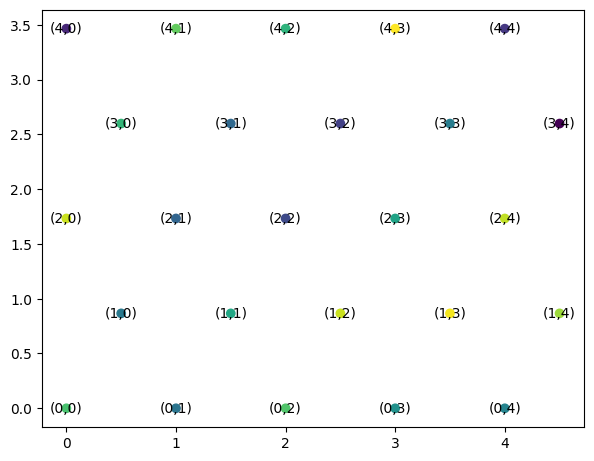

In [ ]:
import matplotlib.pyplot as plt

lattice = generate_lattice((5,5))
lattice_coords = np.array([index_to_cartesian(i,j) for i,j in lattice.keys()])

plt.figure(figsize=(7,7))
plt.scatter(lattice_coords[:,0], lattice_coords[:,1], c=lattice.values(), cmap="viridis")

print_indices = True
if print_indices:
    # Add index labels at each lattice site
    for (i, j), (x, y) in zip(lattice.keys(), lattice_coords):
        plt.text(x, y, f"({i},{j})", fontsize=10, ha='center', va='center', color="black")

plt.gca().set_aspect('equal')
plt.show()

In [4]:
N_rows, N_cols = 100, 100
lattice = generate_lattice((N_rows, N_cols))
# lattice = {site: value if value in [1,2,4,8,16,32] else 0 for site, value in lattice.items()}
lattice_list = [lattice]
N = 100
for i in range(N):
    lattice = update_lattice(lattice, N_rows, N_cols)
    lattice_list.append(lattice)
lattice_list = lattice_list

In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

angles = np.array([0, np.pi/3, 2*np.pi/3, np.pi, -2*np.pi/3, -np.pi/3])
arrow_length = 0.5

fig, ax = plt.subplots(figsize=(5,5))
ax.axis('equal')

# Keep a list of quiver objects
quivers = []

def init():
    """Initialize quivers for the first frame"""
    global quivers
    lattice = lattice_list[0]
    lattice_coords = np.array([index_to_cartesian(i,j) for i,j in lattice.keys()])
    plt.scatter(lattice_coords[:,0], lattice_coords[:,1], cmap="viridis", s=1)

    for site, value in lattice.items():
        x, y = index_to_cartesian(*site)
        for k in range(6):
            if (value >> k) & 1:
                angle = angles[k]
                q = ax.quiver(x, y, arrow_length*np.cos(angle), arrow_length*np.sin(angle),
                              angles='xy', scale_units='xy', scale=1, color='blue', width=0.005)
                quivers.append(q)
    
    max_x, max_y = index_to_cartesian(Nx-1, Ny-1)
    ax.set_xlim(-1, max_x+1)
    ax.set_ylim(-1, max_y+1)
    return quivers

def update(frame):
    """Update arrows for each frame"""
    # Remove previous quivers
    for q in quivers:
        q.remove()
    quivers.clear()
    
    lattice = lattice_list[frame]
    for site, value in lattice.items():
        x, y = index_to_cartesian(*site)
        for k in range(6):
            if (value >> k) & 1:
                angle = angles[k]
                q = ax.quiver(x, y, arrow_length*np.cos(angle), arrow_length*np.sin(angle),
                              angles='xy', scale_units='xy', scale=1, color='blue', width=0.005)
                quivers.append(q)
    ax.set_title(f"Step {frame+1}")
    return quivers

anim = FuncAnimation(fig, update, frames=len(lattice_list), init_func=init, interval=500, blit=False)

# Display animation in Jupyter Notebook
HTML(anim.to_jshtml())

C:\Users\sacka\AppData\Local\Temp\ipykernel_14712\3666547995.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lattice_coords[:,0], lattice_coords[:,1], cmap="viridis", s=1)


KeyboardInterrupt: 

In [9]:
from vispy import app, scene
import vispy
vispy.use("jupyter_rfb")
canvas = scene.SceneCanvas(keys='interactive', show=True, bgcolor='white', size=(600, 600))
canvas.show()
view = canvas.central_widget.add_view()
view.camera = scene.PanZoomCamera(aspect=1)
view.camera.set_range(x=(0, N_cols), y=(0, N_rows))


angles = np.array([0, np.pi/3, 2*np.pi/3, np.pi, -2*np.pi/3, -np.pi/3])
arrow_length = 0.5

# Create line visual for arrows
lines = scene.visuals.Line(connect='segments', color='blue', parent=view.scene)

# Precompute site positions
coords = {site: index_to_cartesian(*site) for site in lattice_list[0].keys()}

frame_idx = 0

def make_arrow_segments(lattice):
    segs = []
    for site, value in lattice.items():
        x, y = coords[site]
        for k in range(6):
            if (value >> k) & 1:
                angle = angles[k]
                dx = arrow_length * np.cos(angle)
                dy = arrow_length * np.sin(angle)
                segs.append([[x, y], [x+dx, y+dy]])
    if segs:
        return np.array(segs, dtype=np.float32).reshape(-1, 2)
    else:
        return np.zeros((0,2), dtype=np.float32)

def update(ev):
    global frame_idx
    frame_idx = (frame_idx + 1) % len(lattice_list)
    segs = make_arrow_segments(lattice_list[frame_idx])
    lines.set_data(pos=segs)
    canvas.update()

timer = app.Timer(interval=0.05, connect=update, start=True)  # ~20 fps

RFBOutputContext()